*   Nama Lengkap : Adisaputra Zidha Noorizki
*   Username     : hi_zidha
*   Email        : hi.zidha@gmail.com

In [ ]:
!pip install tensorflow
!pip install keras
!wget --no-check-certificate \https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip -O /tmp/rockpaperscissors.zip

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [ ]:
import zipfile, os
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/rockpaperscissors/rps-cv-images'

file_list = os.listdir(base_dir)
for file in file_list:
    print(file)

rock
README_rpc-cv-images.txt
scissors
paper


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

input_folder = base_dir
output_folder = '/tmp/rockpaperscissors/dataset'

splitfolders.ratio(input_folder,
                   output_folder,
                   seed=42,
                   ratio=(0.6, 0.4))

train_dir = output_folder+'/train'
val_dir   = output_folder+'/val'

Copying files: 2188 files [00:00, 2755.90 files/s]


In [ ]:
os.listdir(train_dir)

['rock', 'scissors', 'paper']

In [ ]:
os.listdir(val_dir)

['rock', 'paper', 'scissors']

In [ ]:
import cv2
import numpy as np
from PIL import Image

def rotate_image(image, angle):
    image = Image.fromarray(image)
    rotated_image = image.rotate(angle)
    return cv2.cvtColor(np.array(rotated_image), cv2.COLOR_RGB2BGR)

augmentation_dir = '/tmp/rockpaperscissors/aug_train'
os.makedirs(augmentation_dir, exist_ok=True)

angle = 10
categories = os.listdir(train_dir)
for category in categories:
    os.makedirs(os.path.join(augmentation_dir, category), exist_ok=True)

In [ ]:
for category in categories:
    category_dir = os.path.join(train_dir, category)
    image_files = os.listdir(category_dir)

    for image_file in image_files:
        image_path = os.path.join(category_dir, image_file)
        image = cv2.imread(image_path)

        augmented_image = rotate_image(image, angle)
        augmented_image_path = os.path.join(augmentation_dir, category, image_file)
        cv2.imwrite(augmented_image_path, augmented_image)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                        rescale=1./255,
                        rotation_range=20,
                        horizontal_flip=True,
                        shear_range = 0.2,
                        fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
            augmentation_dir,
            target_size=(150, 150),
            batch_size=4,
            class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
            val_dir,
            target_size=(150, 150),
            batch_size=4,
            class_mode='categorical')

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

# Inisialisasi model
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 17, 17, 128)      

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=35,
    validation_data=validation_generator,
    validation_steps=7,
    epochs=25,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback]
)

Epoch 1/25
35/35 [==============================] - ETA: 0s - loss: 1.1204 - accuracy: 0.3357

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 19s 497ms/step - loss: 1.1204 - accuracy: 0.3357 - val_loss: 1.0920 - val_accuracy: 0.3929
Epoch 2/25
35/35 [==============================] - 14s 400ms/step - loss: 1.0978 - accuracy: 0.3357 - val_loss: 1.0832 - val_accuracy: 0.4643
Epoch 3/25
35/35 [==============================] - 14s 389ms/step - loss: 1.0721 - accuracy: 0.4429 - val_loss: 1.1072 - val_accuracy: 0.2500
Epoch 4/25
35/35 [==============================] - 14s 415ms/step - loss: 1.0685 - accuracy: 0.4786 - val_loss: 1.0432 - val_accuracy: 0.4286
Epoch 5/25
35/35 [==============================] - 13s 381ms/step - loss: 0.9098 - accuracy: 0.5714 - val_loss: 1.4273 - val_accuracy: 0.3929
Epoch 6/25
35/35 [==============================] - 14s 388ms/step - loss: 0.5709 - accuracy: 0.7857 - val_loss: 0.4234 - val_accuracy: 0.8214
Epoch 7/25
35/35 [==============================] - 14s 389ms/step - loss: 0.5589 - accuracy: 0.7643 - val_loss: 0.5625 - val_accuracy: 0.7143
Epoch 8/25

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Saving Tz2CIaI6bZXdon61.png to Tz2CIaI6bZXdon61.png
1/1 [==============================] - 0s 32ms/step
Tz2CIaI6bZXdon61.png
rock


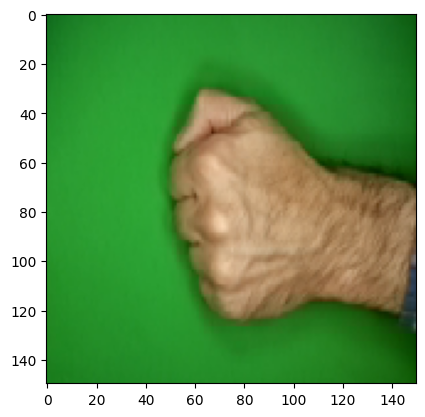

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  # Prediksi kelas dengan probabilitas tertinggi
  classes = model.predict(images, batch_size=10)
  predicted_class = np.argmax(classes)

  class_labels = ['paper', 'rock', 'scissors']
  print(fn)
  print(class_labels[predicted_class])

Saving IZYmxHXE1DVHJfYm.png to IZYmxHXE1DVHJfYm.png
1/1 [==============================] - 0s 32ms/step
IZYmxHXE1DVHJfYm.png
scissors


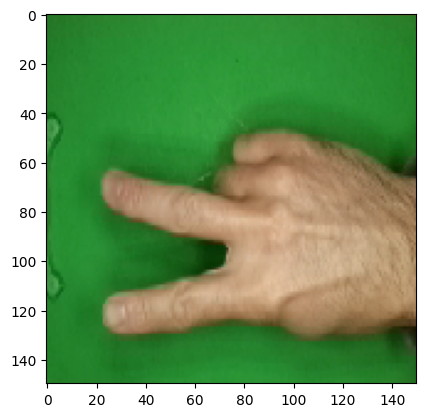

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  # Prediksi kelas dengan probabilitas tertinggi
  classes = model.predict(images, batch_size=10)
  predicted_class = np.argmax(classes)

  class_labels = ['paper', 'rock', 'scissors']
  print(fn)
  print(class_labels[predicted_class])